# Plotting CAM spectral element grids
This notebooks demonstrates a method for plotting data on CAM spectral element grids on a map, using the matplotlib and cartopy libraries. First, define location of some CAM SE output:

In [4]:
output_root = '/home/bhillma/data/acme_scratch/skybridge'
case_name = 'cmdv-mcs.FC5AV1C-04P2.ne30_ne30'
output_file = '%s/%s/run/%s.cam.h0.0001-01.nc'%(output_root, case_name, case_name)

Reading this dataset with the xarray library provides easy access to the data with some nice convenience methods:

In [6]:
from xarray import open_dataset
ds = open_dataset(output_file)

/ascldap/users/bhillma/projects/xarray/xarray/conventions.py:411: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/ascldap/users/bhillma/projects/xarray/xarray/conventions.py:430: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


Select some variable to plot. `FSUTOA` is the CAM name for upwelling solar flux at the top of the atmosphere (i.e., reflected shortwave radiation):

In [16]:
data = ds['FSUTOA'].squeeze()
lat = ds['lat']
lon = ds['lon']
print(data)

<xarray.DataArray 'FSUTOA' (ncol: 48602)>
array([ 148.357803,  147.641724,  141.491745, ...,  100.82412 ,  103.284698,
        102.079643], dtype=float32)
Coordinates:
    time     object    1-02-01 00:00:00
Dimensions without coordinates: ncol
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Upwelling solar flux at top of atmosphere
    cell_methods:       time: mean


We can plot this on a map using the matplotlib and cartopy libraries. The matplotlib library provides basic plotting functionality, and cartopy handles the problem of projecting this data onto a map. Because this data is on an unstructured grid, the matplotlib triangulation library will be used in the process as well, but this is relatively straightforward (unless you want to do more sophisticated stuff or have problems). First, we setup the plot axes with a chosen map projection. For simplicity, use the Plate Carree projection (a cyclindrical equal-angle projection):

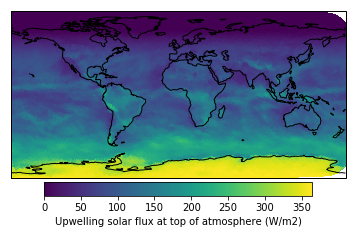

In [35]:
# Cell magic to display plots inline
%matplotlib inline

# Import libraries for plotting data. We use matplotlib for basic
# plotting, and cartopy for map projections.
from matplotlib import pyplot
from cartopy import crs

# Open a figure, and initialize a set of axes with a map projection.
# The map projection can be changed by replacing the 
# projection=crs.PlateCarree() argument with something else, like
# projection=crs.Robinson().
figure = pyplot.figure()
#ax = pyplot.subplot(111, projection=crs.Robinson(central_longitude=0))
ax = pyplot.subplot(111, projection=crs.PlateCarree())
ax.coastlines()
ax.set_global()

# For some reason, cartopy does not like longitude coordinates that
# run from 0 to 360, and seems to expect coordinates from -180 to
# 180 instead. I think this is mostly a problem with the tricontour
# and tripcolor routines I use for unstructured data, but I have not
# really explored this too much. I am sure there is an easier way
# around this, but as a cheap fix I just define a function here to
# move our longitude coordinate from (0, 360) to (-180, 180).
def fix_longitude(lon):
    from numpy import where
    new_longitudes = lon.copy(deep=True)
    new_longitudes[:] = where(lon > 180, lon - 360, lon)
    return new_longitudes

# Use function to fix our longitude coordinate.
fixed_longitudes = fix_longitude(lon)

# Do the plotting. We can use the "tri" versions of contourf and pcolor
# to automatically use the matplotlib triangulation library to deal with
# our unstructured data. Note that cartopy assumes that data passed to
# contourf and pcolor methods is on the same projection as the axes are.
# So, if we chose something other than PlateCarree() above, then we need
# to specify that the data is still in PlateCarree() so that the proper
# transformation is applied.
pl = ax.tripcolor(fixed_longitudes, lat, data, transform=crs.PlateCarree())

# Add a colorbar. The 'shrink' and 'pad' arguments control the size
# and position of the colorbar, and I include them here just to make
# the plot look a little nicer.
cb = pyplot.colorbar(
    pl, orientation='horizontal', shrink=0.8, pad=0.02,
    label='%s (%s)'%(data.long_name, data.units)
)